# Projet SD701 -  Analyse des données

In [3]:
import math as m
from sklearn.preprocessing import StandardScaler
from sklearn import cluster

import pandas as pd
import numpy as np
import requests

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.axis as axis
import seaborn as sns

from xml.dom import minidom
from lxml import etree
from bs4 import BeautifulSoup
import io
from os import listdir
import random
import json

import datetime
import time
from meteostat import Point, Daily, Hourly
from operator import itemgetter

# Ouverture des df

## df_dep

In [ ]:
# fonction pour mettre tous les codes départements en str
def chang_str(x):
    try:
        return str(int(x))
    except:
        return str(x)

In [96]:
# import des départements
with open('depreg.geojson') as fic_depreg:
    depreg = json.load(fic_depreg)
df_dep = pd.DataFrame({'num':[i['properties']['code']for i in depreg['features']],
                      'poly_dep': [i['geometry']['coordinates'] for i in depreg['features']]})
df_dep['num'] = df_dep['num'].apply(chang_str)
df_dep.head()

,num,poly_dep
0,2,"[[[3.172704445659, 50.011996744997], [3.182197..."
1,10,"[[[3.4147888224632, 48.390268550005], [3.42207..."
2,14,"[[[-1.1196198636379, 49.355568981262], [-1.115..."
3,15,"[[[2.5084125130653, 45.478501516921], [2.52443..."
4,28,"[[[0.8148247207739, 48.670163564137], [0.82767..."


In [97]:
# récupération des polygones
def ret_lis(l, w):
    if type(l[0][0]) != float:
        for i in l:
            ret_lis(i, w)
    else:
            w.append(l)
    return w

# fonction permettant d'afficher sur carte les départements
def dep(lis_dep):
    compteur = 0
    for i in df_dep.loc[df_dep['num'].isin(lis_dep), 'poly_dep']:
        w=[]
        polys = ret_lis(i, w)
        #pt_moy = [0,0]
        for poly in polys:
            x, y = [j[0] for j in poly], [j[1] for j in poly]
            plt.plot(x, y, c='k', alpha = 0.3)
            #pt_moy[0] = pt_moy[0] + sum(x)/len(x)/len(polys)
            #pt_moy[1] = pt_moy[1] + sum(y)/len(y)/len(polys)
        #plt.text(pt_moy[0], pt_moy[1], df_dep['num'][compteur], size = 6)
        compteur +=1

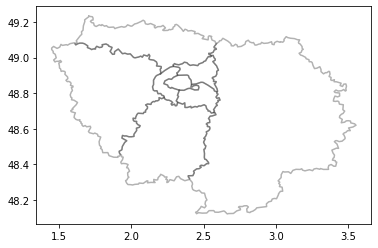

In [98]:
IDF = ['75','91','92', '93', '94', '95', '78', '77']
dep(IDF)

## df_sites

In [16]:
# df_sites
fic = 'dataset/' + "_".join(sorted([f.split("_") for f in listdir('dataset') if f.split("_")[1]=='sites'], 
                                    key=itemgetter(2,3))[-1])
print('ouverture de %s\n' % fic )
df_sites = pd.read_csv(fic, index_col = None, low_memory=False)
df_sites.head()

ouverture de dataset/df_sites_20211125_091353.csv



,code site,nom site,lat,long,alt,Altitude Moyenne,Code INSEE,Code Postal,Commune,Département,...,Statut,Superficie,Population,geo_shape,poly_dep,Code Commune,Code Canton,Code Arrondissement,Code Département,Code Région
0,FR01001,Longlaville-Ecole,49.535004,5.804447,265.0,294.0,54321,54810,LONGLAVILLE,MEURTHE-ET-MOSELLE,...,Commune simple,313.0,2.5,"{""type"": ""Polygon"", ""coordinates"": [[[5.804438...","[[[[5.4555586843759, 49.480931549678], [5.4495...",321,30,1,54,41
1,FR01004,Distroff,49.332497,6.271664,223.0,204.0,57179,57925,DISTROFF,MOSELLE,...,Commune simple,798.0,1.6,"{""type"": ""Polygon"", ""coordinates"": [[[6.250460...","[[[7.6352815933424, 49.054164206261], [7.63470...",179,21,7,57,41
2,FR01005,Hayange,49.324722,6.076108,187.0,253.0,57306,57700,HAYANGE,MOSELLE,...,Chef-lieu canton,1223.0,15.5,"{""type"": ""Polygon"", ""coordinates"": [[[6.094813...","[[[7.6352815933424, 49.054164206261], [7.63470...",306,15,8,57,41
3,FR01006,Florange,49.320830,6.140000,158.0,177.0,57221,57190,FLORANGE,MOSELLE,...,Chef-lieu canton,1318.0,11.2,"{""type"": ""Polygon"", ""coordinates"": [[[6.132507...","[[[7.6352815933424, 49.054164206261], [7.63470...",221,39,8,57,41
4,FR01009,Gandrange,49.271393,6.132500,180.0,180.0,57242,57175,GANDRANGE,MOSELLE,...,Commune simple,411.0,2.9,"{""type"": ""Polygon"", ""coordinates"": [[[6.153646...","[[[7.6352815933424, 49.054164206261], [7.63470...",242,22,8,57,41


## df_tot

In [124]:
# ouverture du dernier df_tot

fic = 'dataset/' + "_".join(sorted([f.split("_") for f in listdir('dataset') if f.split("_")[1]=='tot'], 
                                    key=itemgetter(2,3))[-1])
print('ouverture de %s\n' % fic )
df_tot = pd.read_csv(fic)
df_tot.drop(df_tot.columns[0], axis = 1, inplace = True)
df_tot['GDH'] = pd.to_datetime(df_tot['GDH'])
df_tot['Code Département'] = df_tot['Code Département'].apply(chang_str)
df_tot.head()

ouverture de dataset/df_tot_20211125_210212.csv



,GDH,code site,PicJourConsoNat,type_poll,verif,valid,mesure,mesure_max,mesure_min,lat,...,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,Jx,Jy
0,2018-09-17,FR02011,53588.0,1,3,1,0.183333,0.500000,0.00,43.43786,...,25.9,0.0,NaN,84.3,5.8,27.8,1019.8,NaN,1.000000,0.000000
1,2018-09-20,FR02011,54243.0,1,3,1,1.050000,2.000000,0.50,43.43786,...,29.9,0.0,NaN,40.2,6.1,35.2,1017.5,NaN,-0.900969,0.433884
2,2018-09-22,FR02011,47614.0,1,3,1,3.530000,29.800000,-0.30,43.43786,...,27.9,0.0,NaN,323.1,18.5,55.5,1019.0,NaN,-0.222521,-0.974928
3,2018-09-24,FR02011,53454.0,1,2,1,19.148053,105.650000,0.25,43.43786,...,23.9,0.0,NaN,323.0,33.2,81.5,1019.4,NaN,1.000000,0.000000
4,2018-09-27,FR02011,54560.0,1,3,1,1.283689,3.428571,0.00,43.43786,...,23.5,0.0,NaN,329.3,9.9,22.2,1028.9,NaN,-0.900969,0.433884


In [125]:
# standardisation des métriques utilisées, on groupe par type de polluant
poll = set(df_tot['type_poll'])
dataset=[]
for i in poll:
    part = df_tot.groupby('type_poll').get_group(i)
    for j in ['mesure', 'mesure_max', 'mesure_min']:
        a = StandardScaler().fit_transform(np.array(part[j]).reshape(-1,1))
        part[j] = a
    dataset.append(part)
df_tot = pd.concat(dataset)
df_tot.reset_index(inplace = True)
df_tot.drop(df_tot.columns[0], axis = 1, inplace = True)
df_tot.head()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

,GDH,code site,PicJourConsoNat,type_poll,verif,valid,mesure,mesure_max,mesure_min,lat,...,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,Jx,Jy
0,2018-09-17,FR02011,53588.0,1,3,1,-0.378564,-0.335083,-0.154467,43.43786,...,25.9,0.0,NaN,84.3,5.8,27.8,1019.8,NaN,1.000000,0.000000
1,2018-09-20,FR02011,54243.0,1,3,1,-0.195002,-0.267714,0.060764,43.43786,...,29.9,0.0,NaN,40.2,6.1,35.2,1017.5,NaN,-0.900969,0.433884
2,2018-09-22,FR02011,47614.0,1,3,1,0.330269,0.980861,-0.283606,43.43786,...,27.9,0.0,NaN,323.1,18.5,55.5,1019.0,NaN,-0.222521,-0.974928
3,2018-09-24,FR02011,53454.0,1,2,1,3.638216,4.387494,-0.046852,43.43786,...,23.9,0.0,NaN,323.0,33.2,81.5,1019.4,NaN,1.000000,0.000000
4,2018-09-27,FR02011,54560.0,1,3,1,-0.145506,-0.203553,-0.154467,43.43786,...,23.5,0.0,NaN,329.3,9.9,22.2,1028.9,NaN,-0.900969,0.433884


# Visualisation

In [193]:
# fonction d'affichage des moyennes des mesures sur une période donnée et dans des départements donnés
def graph_poll(date_start, date_end, lis_dep, lab = False, graph = False):
    a = df_tot.loc[df_tot['Code Département'].isin(lis_dep)]
    a = a.set_index('GDH').loc[date_start:date_end].groupby(['code site']).agg({'mesure':'mean', 
                                                           'Code Département': 'first',
                                                           'lat':'first',
                                                           'long': 'first'})
    if graph == True:
        plt.figure(figsize=(15,10))
    dep(lis_dep)
    var = plt.scatter(a['long'], a['lat'], c = a['mesure'], cmap=plt.cm.Spectral_r,
                      edgecolors='none', s=200, alpha = 0.7)
    plt.xlabel('longitude', size = 15)
    plt.ylabel('lattitude', size = 15)
    plt.colorbar(var, label='pollution')
    if date_start == date_end:
        plt.title(f'Pollution en {date_end}', size = 20)
    else:
        plt.title(f'Pollution du {date_start} au {date_end}', size = 20)
    if lab == True:
        a = pd.merge(a, df_sites[['code site','Commune']], left_on = 'code site', right_on = 'code site', how = 'left')
        for x, y, text in zip(a['long'], a['lat'], a['Commune']):
            plt.annotate(text, (x,y))
    if graph == True:
        plt.show()

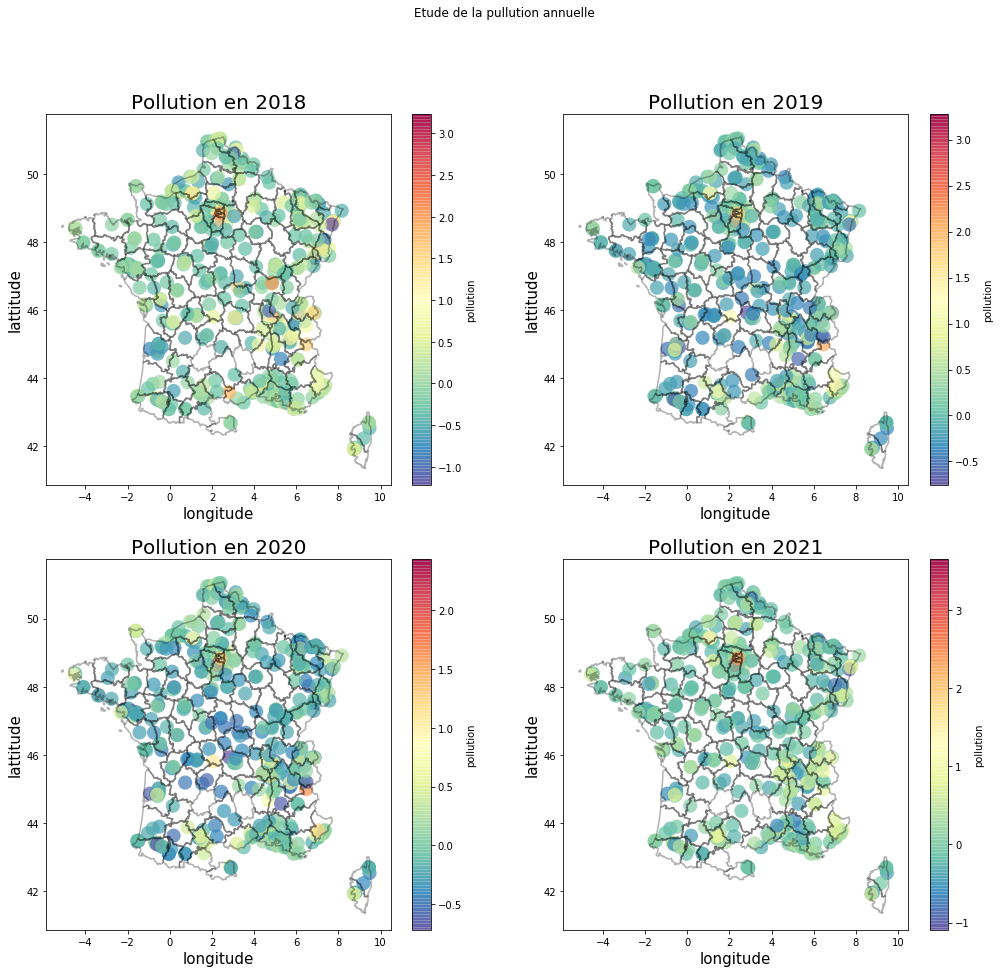

In [194]:
plt.figure(figsize=(17,15))
plt.suptitle('Etude de la pullution annuelle')
for i in range(4):
    plt.subplot(2, 2, i+1)
    graph_poll(str(2018+i), str(2018+i), set(df_tot['Code Département']))
plt.show()

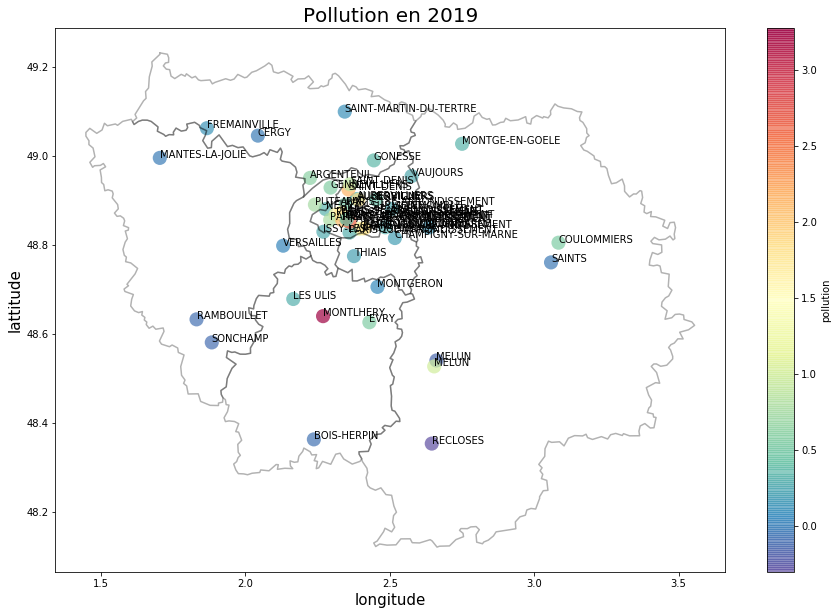

In [196]:
graph_poll('2019', '2019', IDF, lab=True, graph=True)

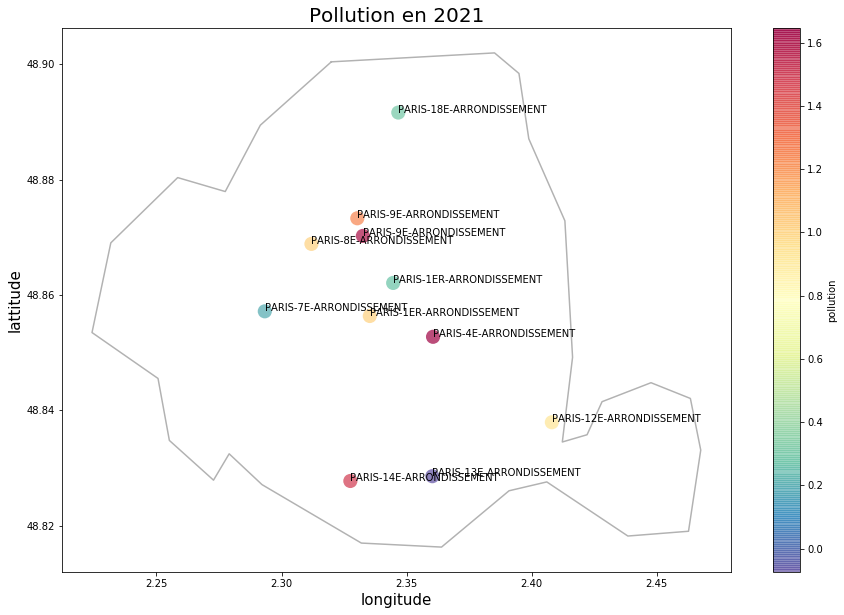

In [199]:
graph_poll('2021', '2021', ['75'], lab=True, graph = True)

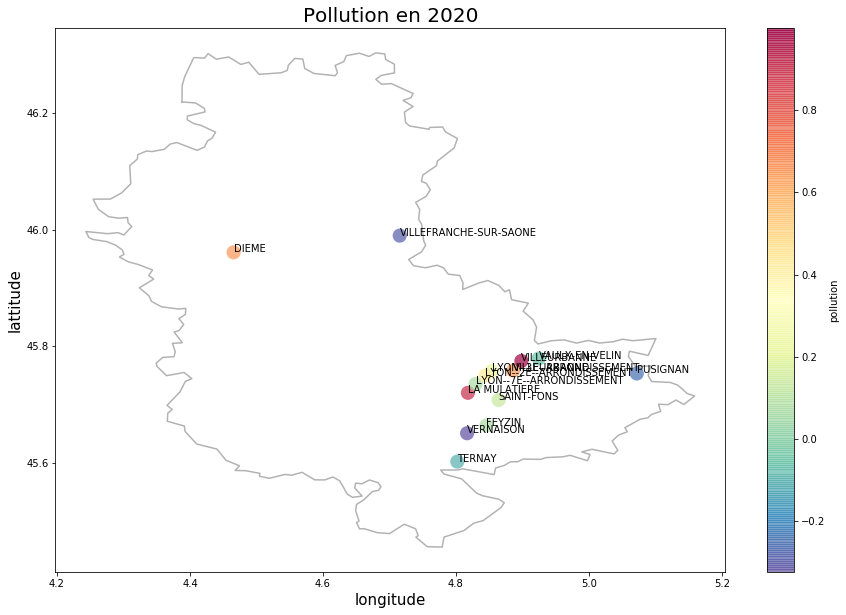

In [186]:
graph_poll('2020', '2020', ['69'], lab=True)

# KMeans

In [200]:
# standardisation des métriques utilisées, on groupe par type de polluant
df_tot_std = df_tot.copy()
for i in ['mesure','mesure_max','mesure_min', 'alt', 'tavg', 'tmin', 'tmax',
          'prcp','snow','wdir','wspd','wpgt','pres','tsun', 'PicJourConsoNat', 'Population',
         'Jx', 'Jy']:
    a = StandardScaler().fit_transform(np.array(df_tot_std[i]).reshape(-1,1))
    df_tot_std[i] = a

# standardisation des coordonnées: on garde aussi les vraies coordonnées pour les mapper
df_tot_std['lat_cr'] = StandardScaler().fit_transform(np.array(df_tot['lat']).reshape(-1,1))
df_tot_std['long_cr'] = StandardScaler().fit_transform(np.array(df_tot['lat']).reshape(-1,1))

# nettoyage des données:
#df_tot = df_tot#.fillna(method='bfill')
#df_tot = df_tot.loc[df_tot['mean']<10]
    
df_tot_std.head()

,GDH,code site,PicJourConsoNat,type_poll,verif,valid,mesure,mesure_max,mesure_min,lat,...,snow,wdir,wspd,wpgt,pres,tsun,Jx,Jy,lat_cr,long_cr
0,2018-09-17,FR02011,-0.640969,1,3,1,-0.378564,-0.335083,-0.154467,43.43786,...,NaN,-0.963141,-1.013243,-0.631070,0.336727,NaN,1.440628,-0.066537,-1.492763,-1.492763
1,2018-09-20,FR02011,-0.581588,1,3,1,-0.195002,-0.267714,0.060764,43.43786,...,NaN,-1.393749,-0.970517,-0.093683,0.083441,NaN,-1.231079,0.552702,-1.492763,-1.492763
2,2018-09-22,FR02011,-1.182561,1,3,1,0.330269,0.980861,-0.283606,43.43786,...,NaN,1.368590,0.795475,1.380501,0.248628,NaN,-0.277558,-1.457955,-1.492763,-1.492763
3,2018-09-24,FR02011,-0.653117,1,2,1,3.638216,4.387494,-0.046852,43.43786,...,NaN,1.367614,2.889031,3.268617,0.292677,NaN,1.440628,-0.066537,-1.492763,-1.492763
4,2018-09-27,FR02011,-0.552849,1,3,1,-0.145506,-0.203553,-0.154467,43.43786,...,NaN,1.429129,-0.429326,-1.037741,1.338858,NaN,-1.231079,0.552702,-1.492763,-1.492763


On regroupe les polluants en prenant la moyenne de pollution par jour et par site 

In [202]:
#df_mean = pd.DataFrame(df_tot.groupby(list(newidx)).agg({'mean':'mean'})).reset_index()
df_mean = df_tot_std.groupby(['code site', 'Code Département']).agg({
                                         'PicJourConsoNat':'mean',
                                        'Population':'mean',
                                         'alt':'mean',
                                         'lat':'first',
                                         'lat_cr':'first',
                                         'long':'first',
                                         'long_cr':'first',
                                         'prcp':'mean',
                                         'pres':'mean',
                                         'snow':'mean',
                                         'tavg':'mean',
                                         'tmax':'mean',
                                         'tmin':'mean',
                                         'tsun':'mean',
                                         'wdir':'mean',
                                         'wpgt':'mean',
                                         'wspd':'mean',
                                        'mesure':'mean'}).reset_index().fillna(method='bfill')

On teste tout d'abord le KMeans sur toutes les métriques numériques


In [239]:
# clustering par k-means:
def km(df, nb_clust):
    dfk = df.fillna(0)
    #.loc[df_mean['GDH'].dt.]
    #dfk = dfk.loc[dfk['mean']<10]

    kmeans_algo = cluster.KMeans(n_clusters=nb_clust)
    kmeans_results = kmeans_algo.fit_transform(dfk[['mesure', 'Population',
                                                    'alt', 
                                                    #'lat_cr', 'long_cr',
                                                    #'PicJourConsoNat',
                                                    'lat', 'long',
                                                    'tavg', 'snow',  'pres', 'wspd', 
                                                    ]])
    
    classification = list(kmeans_algo.labels_)
    dfk['classification'] = pd.DataFrame(classification)
    colormap = np.array(["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)]) for _ in range(nb_clust)])
    #création d'une liste comportant tous les binômes de paramètres étudiés
    L = ['alt',  'tavg','pres', 'wspd', 'lat', 'Population']

    #représentation des six nuages de points pour identifier visuellement le(s) binôme(s) le(s) plus pertinent:
    plt.figure(figsize=(15,10))
    for i in range(len(L)):
        plt.subplot(2,3,i+1)
        plt.scatter(dfk[L[i]],dfk['mesure'], c=colormap[classification], alpha = 0.5, s=10)
        plt.title('Pollution'+' / '+dfk[L[i]].name)
    plt.subplot(2,3,6)
    #plt.scatter(dfk['Jx'],dfk['Jy'], c=colormap[classification], alpha = 0.5, s=10)
    #plt.title('Jy/Jx')
    plt.show()
    
    # Affichage sur la carte
    plt.figure(figsize=(12,12))

    dep(set(dfk['Code Département']))
            
    for i in set(classification):
        plt.scatter(dfk.loc[dfk['classification'] == i, 'long'], 
                    dfk.loc[dfk['classification'] == i, 'lat'],
                    s=200, alpha = 0.5,
                    c=colormap[i],
                    label = f'clust {str(i+1)}')
    plt.legend()
    plt.xlabel('longitude')
    plt.ylabel('lattitude')
    #plt.legend()
    plt.title(f'K-means à {nb_clust} clusters', size = 20)
    plt.show()

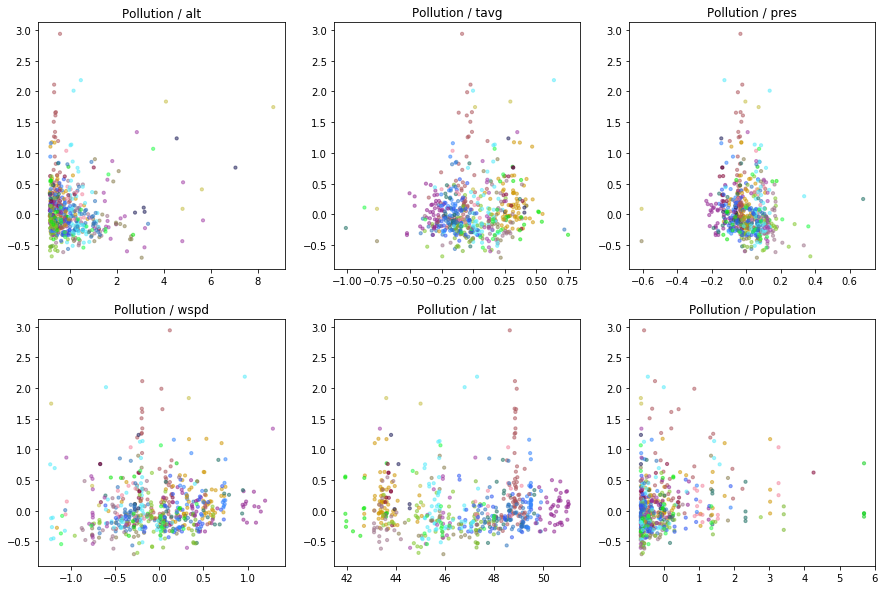

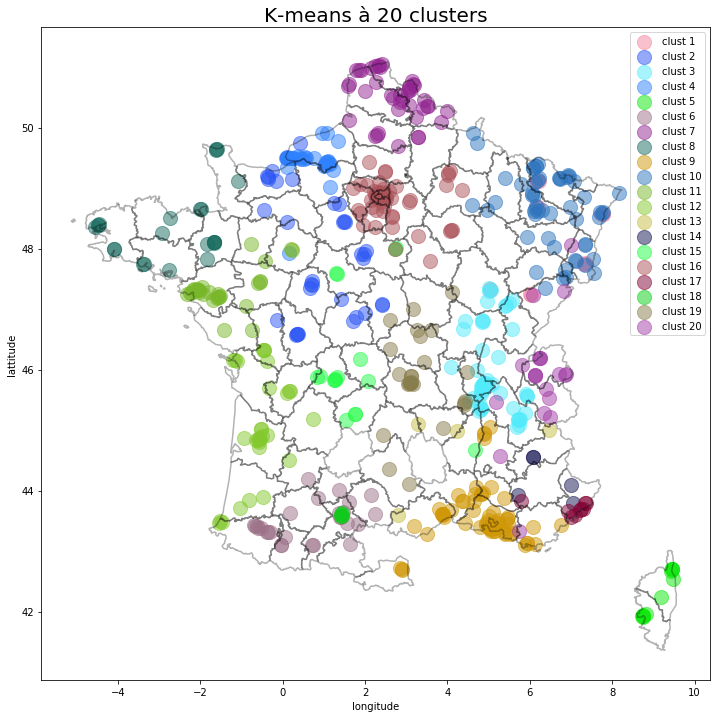

In [240]:
km(df_mean, 20)

On remarque que le Kmeans effectué ci-dessus n'est pas adapté car la distance sur les métriques de coordonnées prend le pas sur les autres métriques. il faut alors augmenter la valeur de pollution

In [ ]:
df_mean['mean'] = df_mean['mean'] * 100

In [234]:
df_sites.loc[df_sites['Code Département'] == '91', 'poly_dep']

105    [[[2.2265538842831, 48.776101996393], [2.23297...
112    [[[2.2265538842831, 48.776101996393], [2.23297...
130    [[[2.2265538842831, 48.776101996393], [2.23297...
136    [[[2.2265538842831, 48.776101996393], [2.23297...
142    [[[2.2265538842831, 48.776101996393], [2.23297...
Name: poly_dep, dtype: object

In [233]:
df_mean.loc[df_mean['code site'] == 'FR04049']

,Région,code site,Code Département,Jx,Jy,PicJourConsoNat,Population,alt,lat,lat_cr,...,pres,snow,tavg,tmax,tmin,tsun,wdir,wpgt,wspd,mean
300,ILE-DE-FRANCE,FR04049,91,0.038325,-0.055465,-0.020988,-0.313782,0.005428,48.679443,0.768325,...,-0.065788,0.780702,-0.060905,-0.164103,0.041758,NaN,0.037786,0.012198,0.054785,1.46956


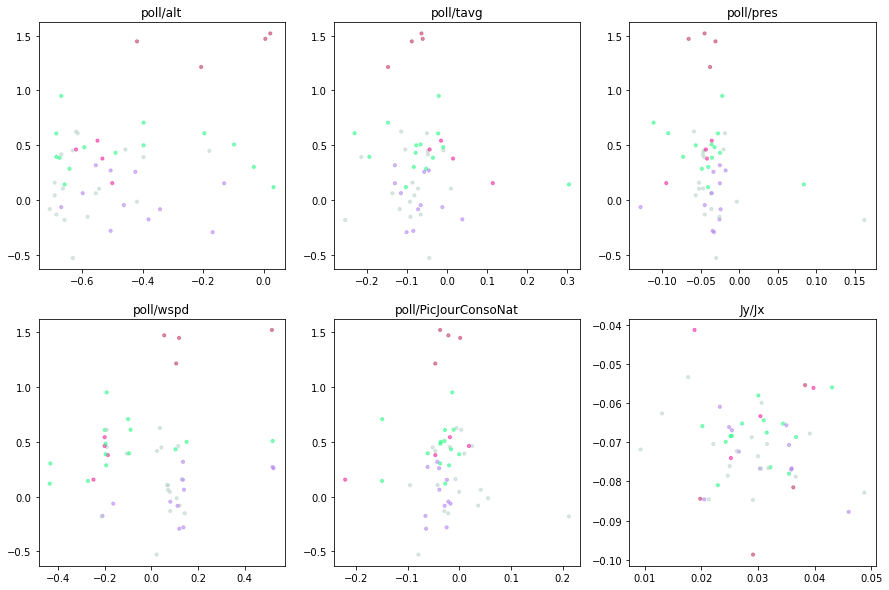

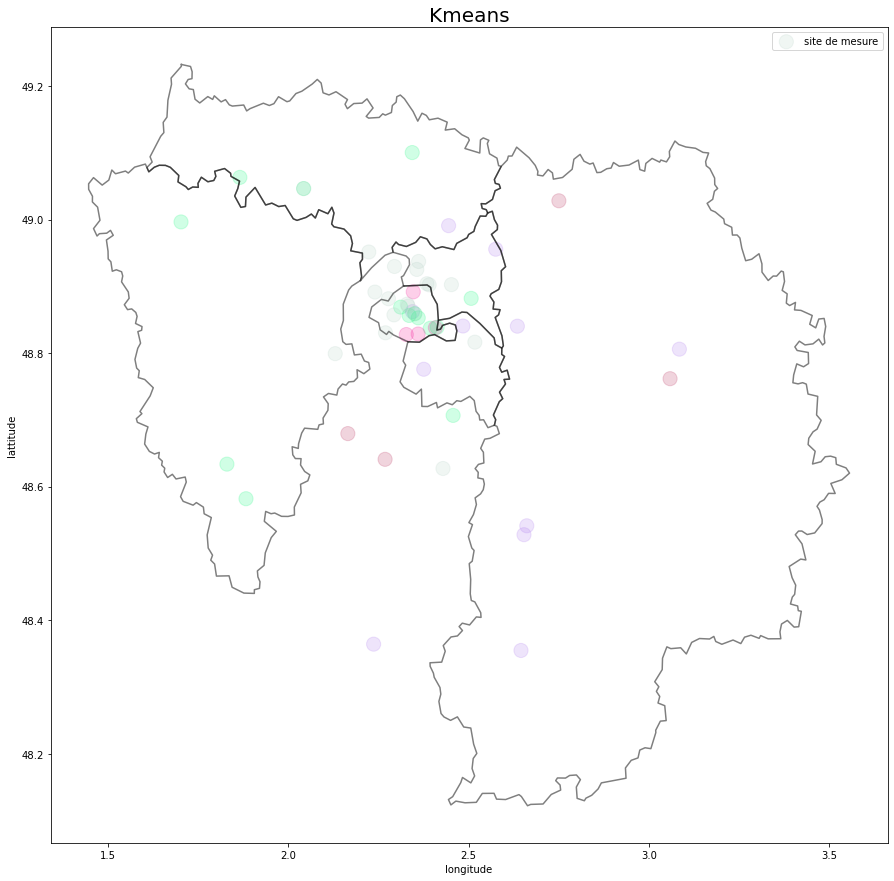

In [222]:
df_idf = df_mean.loc[df_mean['Région'] == 'ILE-DE-FRANCE']
km(df_idf, 5)